# ABS tutorial 02

## basics of wrapped-in pseudo-$C_\ell$ estimator

By default we use [NaMaster](https://github.com/LSSTDESC/NaMaster).

To validate the ABS method we have simulated a few foregrounds maps including dust and synchrotron at 30, 95, 150 and 353 GHz, using PySM package. CAMB is utilized to predict the CMB power spectra with respect to the Planck best fit 2018 results, from which random realizations of CMB anisotropies are obtained. For the tensor-to-scalar ratio, we set it as 0.05 for the generation of CMB maps. White noise maps are generated according to the Planck level.

In [1]:
import numpy as np
import healpy as hp
import matplotlib
import abspy as ap
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

### read in maps

In [2]:
NSIDE = 128
map30 = hp.read_map('./data/TQU_30GHz_r7.fits',field=[0,1,2],dtype=np.float64,verbose=0)
map95 = hp.read_map('./data/TQU_95GHz_r7.fits',field=[0,1,2],dtype=np.float64,verbose=0)
map150 = hp.read_map('./data/TQU_150GHz_r7.fits',field=[0,1,2],dtype=np.float64,verbose=0)
map353 = hp.read_map('./data/TQU_353GHz_r7.fits',field=[0,1,2],dtype=np.float64,verbose=0)
mapcmb = hp.read_map('./data/TQU_CMB_r7.fits',field=[0,1,2],dtype=np.float64,verbose=0)
print (map95.shape, map95.dtype)

(3, 196608) float64


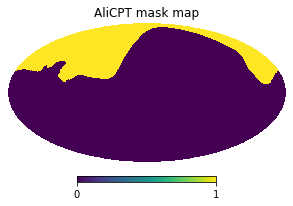

In [3]:
mask = hp.read_map('./data/ali_mask_r7.fits',dtype=bool,verbose=False)

fig = matplotlib.pyplot.figure(figsize=(5,5))
gs = matplotlib.gridspec.GridSpec(5, 5)
fig.add_subplot(gs[0:5, 0:5])
hp.mollview(mask,title='AliCPT mask map',hold=True)

### use `pstimator` functions (with NaMaster support)

- call the `pstimator` only once

(1, 384)

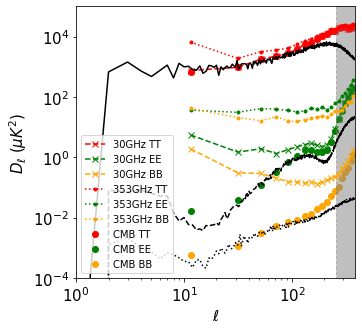

In [4]:
est = ap.pstimator(nside=NSIDE,mask=mask.reshape(1,-1), aposcale=5.0, psbin=20)

auto_cmb_t = est.auto_t(mapcmb[0].reshape(1,-1),fwhms=0.01)
auto_cmb_eb = est.auto_eb(mapcmb[1:].reshape(2,-1),fwhms=0.01)
auto_30_t = est.auto_t(map30[0].reshape(1,-1),fwhms=0.01)
auto_30_eb = est.auto_eb(map30[1:].reshape(2,-1),fwhms=0.01)
auto_353_t = est.auto_t(map353[0].reshape(1,-1),fwhms=0.01)
auto_353_eb = est.auto_eb(map353[1:].reshape(2,-1),fwhms=0.01)

fig,ax = matplotlib.pyplot.subplots(figsize=(5,5))

ax.scatter(auto_cmb_t[0],auto_cmb_t[1],
           color='red',marker='o',label=r'CMB TT')
ax.scatter(auto_cmb_eb[0],auto_cmb_eb[1],
           color='green',marker='o',label=r'CMB EE')
ax.scatter(auto_cmb_eb[0],auto_cmb_eb[2],
           color='orange',marker='o',label=r'CMB BB')

ax.plot(auto_30_t[0],auto_30_t[1],
        color='red',linestyle='--',marker='x',label=r'30GHz TT')
ax.plot(auto_30_eb[0],auto_30_eb[1],
        color='green',linestyle='--',marker='x',label=r'30GHz EE')
ax.plot(auto_30_eb[0],auto_30_eb[2],
        color='orange',linestyle='--',marker='x',label=r'30GHz BB')

ax.plot(auto_353_t[0],auto_353_t[1],
        color='red',linestyle=':',marker='.',label=r'353GHz TT')
ax.plot(auto_353_eb[0],auto_353_eb[1],
        color='green',linestyle=':',marker='.',label=r'353GHz EE')
ax.plot(auto_353_eb[0],auto_353_eb[2],
        color='orange',linestyle=':',marker='.',label=r'353GHz BB')

cmb_cl = hp.anafast(mapcmb)
ell = np.arange(cmb_cl.shape[1])
ax.plot(0.5*ell*(ell+1)/np.pi*cmb_cl[0],
        color='black',linestyle='-')
ax.plot(0.5*ell*(ell+1)/np.pi*cmb_cl[1],
        color='black',linestyle='--')
ax.plot(0.5*ell*(ell+1)/np.pi*cmb_cl[2],
        color='black',linestyle=':')

ax.fill_between((2*NSIDE,3*NSIDE),(1e-4,1e-4),(1e5,1e5),
                color='gray',linestyle='--',alpha=0.5)

ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(loc=3)
ax.set_xlabel(r'$\ell$',fontsize=15)
ax.set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_ylim((1.e-4,1.e5))
ax.set_xlim((1,3*NSIDE))

- PS estimator function correctness check, here we utilize **workspace** recorded from the previous runs of `pstimator`.

(1, 384)

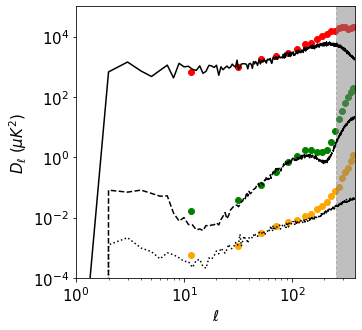

In [5]:
cross_cmb_t = est.cross_t(np.vstack([mapcmb[0],mapcmb[0]]),auto_cmb_t[-1],
                          fwhms=[0.01,0.01])
cross_cmb_eb = est.cross_eb(np.vstack([mapcmb[1:].reshape(2,-1),mapcmb[1:].reshape(2,-1)]),auto_cmb_eb[-1],
                            fwhms=[0.01,0.01])


fig,ax = matplotlib.pyplot.subplots(figsize=(5,5))

ax.scatter(cross_cmb_t[0],cross_cmb_t[1],
           color='red',marker='o')
ax.scatter(cross_cmb_eb[0],cross_cmb_eb[1],
           color='green',marker='o')
ax.scatter(cross_cmb_eb[0],cross_cmb_eb[2],
           color='orange',marker='o')

cmb_cl = hp.anafast(mapcmb)
ell = np.arange(cmb_cl.shape[1])
ax.plot(0.5*ell*(ell+1)/np.pi*cmb_cl[0],
        color='black',linestyle='-')
ax.plot(0.5*ell*(ell+1)/np.pi*cmb_cl[1],
        color='black',linestyle='--')
ax.plot(0.5*ell*(ell+1)/np.pi*cmb_cl[2],
        color='black',linestyle=':')

ax.fill_between((2*NSIDE,3*NSIDE),(1e-4,1e-4),(1e5,1e5),
                color='gray',linestyle='--',alpha=0.5)

ax.set_yscale('log')
ax.set_xscale('log')
#ax.legend(loc=3)
ax.set_xlabel(r'$\ell$',fontsize=15)
ax.set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_ylim((1.e-4,1.e5))
ax.set_xlim((1,3*NSIDE))

comments: the tilting up of re-estimated PS at high anular modes is caused by the beam correction

end